# Detecting Tuberculosis in X-Rays

## 📖 Background
Tuberculosis (TB) is one of the most common and deadly respiratory diseases in the world, causing about [1.25 million people in 2023](https://www.who.int/teams/global-programme-on-tuberculosis-and-lung-health/tb-reports/global-tuberculosis-report-2024/tb-disease-burden/1-2-tb-mortality).
Doctors often use chest X-rays to help detect TB. However, looking at many X-rays by hand can be slow and difficult.

In this challenge, you will build a simple machine learning model that can help classify chest X-ray images into two groups:

- Healthy lungs
- Lungs affected by TB

This is not about building a “perfect” model. The focus should be on how you describe your process, decisions, and learnings.



## 🩻 The Data

<img src="x-rays_sample.png" align="center"/>
&nbsp

You are given a small dataset from the Sakha-TB dataset:

- Training data: 150 healthy + 150 TB images (300 total)
- Test data: 50 healthy + 50 TB images (100 total)

These images are in the **data.zip** file at the root of the notebook. They will then be in the `data/chestxray` folder, which is further divided into `test` and `train`, both containing `healthy` and `tb` folders with the images inside.

# Libraries

In [2]:
!pip install opencv-python==4.9.0.80
!pip install "numpy<2.0" --force-reinstall

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Data handling libaraies
import numpy as np
import pandas as pd
import zipfile

# Operating system
import os

# visualization libarary
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import PIL #Python Imaging Library
from PIL import Image
from tqdm import tqdm
import cv2
import seaborn as sns


#warning management
import warnings
warnings.filterwarnings("ignore")

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.applications.resnet import ResNet50
from keras.applications import DenseNet121

#evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix


2025-09-30 09:43:33.116571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759225413.131896    5304 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759225413.136475    5304 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759225413.149042    5304 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759225413.149059    5304 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759225413.149062    5304 computation_placer.cc:177] computation placer alr

# Data directory

In [4]:
# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

base_dir = 'data/chestxrays'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.19.0


# visualization

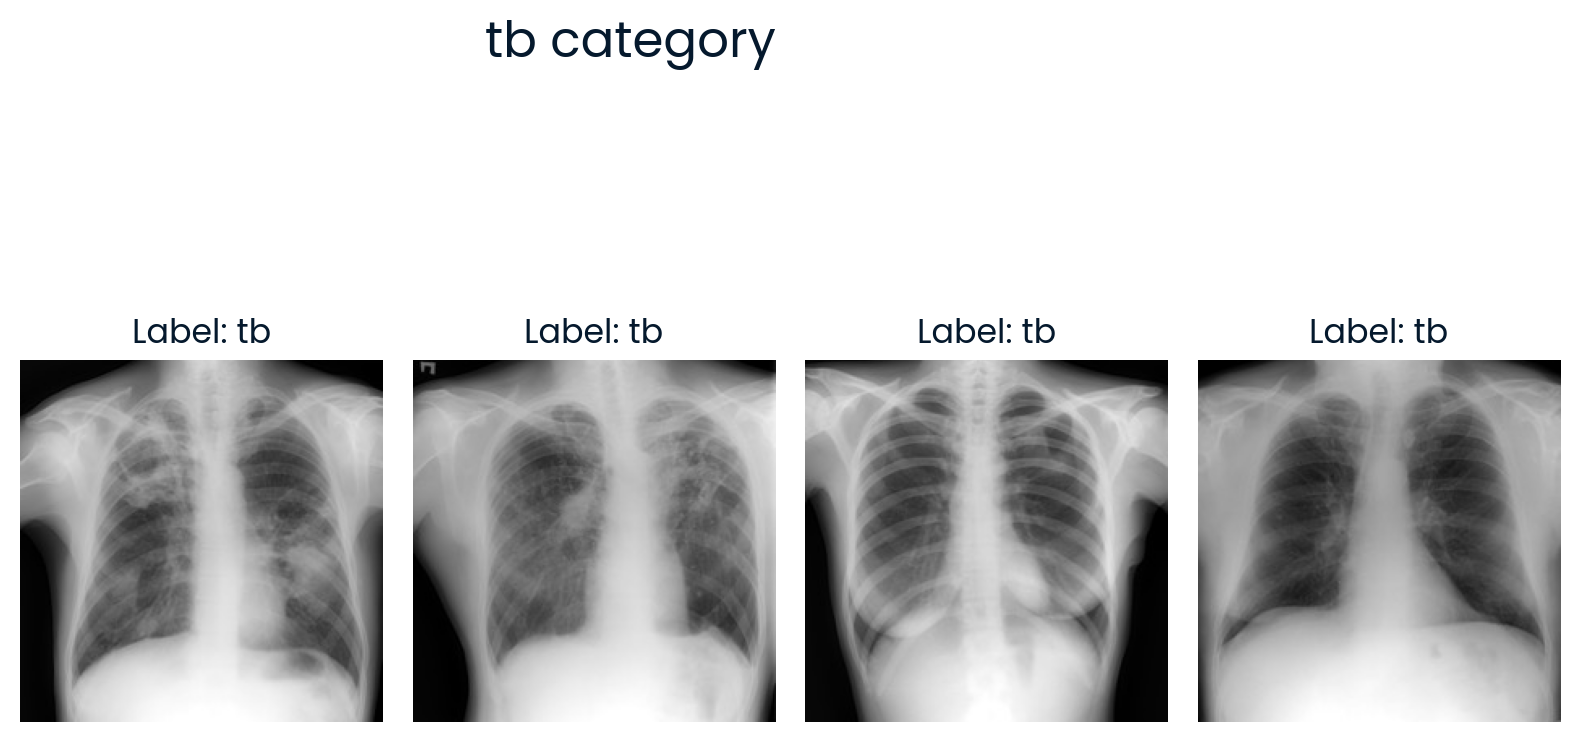

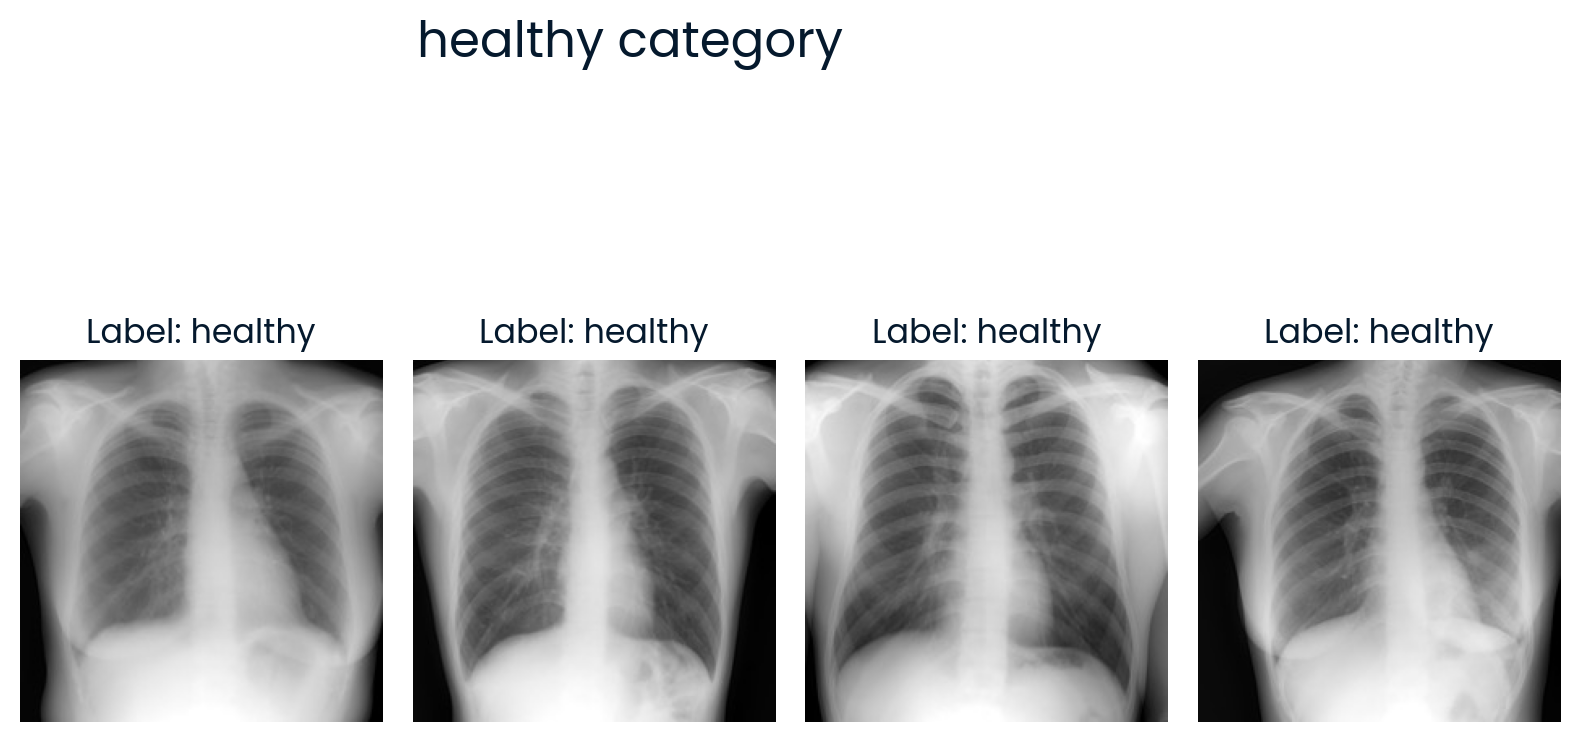

In [5]:
categories = ['tb', 'healthy']

for category in categories:
    path = os.path.join(train_dir, category)
    images = os.listdir(path)
    
    fig, ax = plt.subplots(1, 4, figsize=(8, 8))
    fig.suptitle(f"{category} category", fontsize=18, x=0.4, y=.8)

    for i in range(4):
        img = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img)
        imga = Image.open(img_path)
        img_convert = imga.convert('RGB')
        imga_array = np.array(img_convert)
        
        ax[i].imshow(imga_array)
        ax[i].set_title(f"Label: {category}")
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
imga_array.shape # if you struggle to identify your own images then it's less likely you'll train an algorithm to. This is often a useful starting point when considering the level of scaling that might be appropriate.

(224, 224, 3)

# Load Data

**Notes** 
- Sample is a single row of data.
- iterations: Number of batches to complete one epoch.
- An Epoch is a full pass of the entire training dataset through the model. It is used to measure the number of times the model has seen the entire dataset.
- Batch size is the number of samples to work through before updating the model's parameter/weights.


In [7]:
img_height = 224
img_width = 224
batch_size = 15
#The training dataset contains 300 samples (which is not very large) and to ensure the model learns the variability of the data, a small batch size is needed.

In [8]:

train_ds = tf.keras.utils.image_dataset_from_directory(
   train_dir,
    image_size= (img_height, img_width),
    batch_size = batch_size,
    seed = 491,
    verbose = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size= (img_height, img_width),
    batch_size = batch_size,
    seed = 491,
    verbose = True
)


Found 302 files belonging to 2 classes.


2025-09-30 09:43:37.820082: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 100 files belonging to 2 classes.


# Data Augmentation: 
Increases the size and diversity of the training dataset.This makes the data more robust and immune to overfitting

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation to ensure the model doesn't over fit
train_datagen = ImageDataGenerator(
        rescale=1./255, #Brings raw pixel values from [0–255] into a smaller range like [0–1]This prevents very     large numbers from exploding gradients and ensures the model starts training smoothly.
        zoom_range=0.2,
        brightness_range = (0.5, 1.5),
        vertical_flip = True,
        horizontal_flip=True,
        rotation_range = 5,
        width_shift_range= 0.1, #Chest X-rays may not always be perfectly centered (e.g., different machines,
        height_shift_range=0.1) #patient movement, technician alignment).By randomly shifting the X-rays during training, the model learns to ignore small positional variations and focus on TB-related features (like lung opacities, cavities, consolidation).

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(img_height, img_width),  
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode='binary',
        shuffle = True, # shuffled to introduce more randomness in the training process
        seed = 419,
        classes = ['healthy', 'tb']
)  

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode='binary',
        shuffle = False,
        seed = 419,
        classes = ['healthy', 'tb']

)


Found 302 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Small CNN model

**Batch Normalization:**

Batch normalization normalizes the activations within each mini-batch, helping to stabilize the training process and improve the model's performance. The stability is achieved by reducing internal covariate shift (changes in the distribution of activations across layers).

In [10]:

small_cnn = Sequential([
    #first Input layer with 
    layers.Conv2D(64, (3,3 ), padding="same", activation="relu", input_shape = (img_height,img_width, 3)),
    layers.BatchNormalization(),

    #first convolutional layer
    layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"),
    layers.BatchNormalization(),
    layers.AveragePooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    #second convolutional layer
    layers.Conv2D(64, (3, 3), padding = "same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # # third convolution layer: To ensure the model detects more patterns
    # layers.Conv2D(512, (3, 3), padding = "same", activation="relu"),
    # layers.BatchNormalization(),
    # layers.AveragePooling2D(pool_size=(2,2)),
    # layers.Dropout(0.25),

    # flatten turns it in 1D
    layers.Flatten(),
    layers.Dense(128, activation = "relu"), # learn the patterns
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1,activation="sigmoid") # makes the prediction

])
# small_cnn = Sequential([
#     #first Input layer
#     layers.Conv2D(64, (3,3 ), padding="same", activation="relu", input_shape = (img_height,img_width, 3)),

#     #first convolutional layer
#     layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"),

#     layers.MaxPooling2D(),

#     layers.Dropout(0.25),

#     #second convolutional layer

#     layers.Conv2D(64, (3, 3), padding = "same", activation="relu"),

#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),

#     # flatten turns it in 1D
#     layers.Flatten(),
#     layers.Dense(128, activation = "relu"), # learn the patterns
#     layers.Dropout(0.5),
#     layers.Dense(1, activation="sigmoid") # makes the prediction


# ])

small_cnn.compile(
    optimizer=tf.keras.optimizers.RMSprop (),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = ["accuracy"]
)



In [11]:
small_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,730,273 (98.15 MB)

 Trainable params: 25,729,697 (98.15 MB)

 Non-trainable params: 576 (2.25 KB)

In [12]:
#ModelCheckpoint saves the model at the epoch where it performs best on the validation set. This also aids to pick the best epoch

call_back = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor="accuracy",
    verbose=1,
    mode='max',
    save_best_only=True,
)

#train model on train set and validation set
epochs = 8

history = small_cnn.fit(
    train_generator,
    epochs=epochs,
    callbacks=[call_back]
)

Epoch 1/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5102 - loss: 1.7036
Epoch 1: accuracy improved from -inf to 0.51987, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.5106 - loss: 1.6897
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5150 - loss: 0.9049
Epoch 2: accuracy did not improve from 0.51987
21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.5141 - loss: 0.9059
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4798 - loss: 1.0266
Epoch 3: accuracy did not improve from 0.51987
21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.4788 - loss: 1.0278
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5917 - loss: 0.7988
Epoch 4: accuracy improved from 0.51987 to 0.55960, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.5902 - loss: 0.7996
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5506 - loss: 0.9031
Epoch 5: accuracy did not improve

In [16]:
small_cnn.save("small cnn model.h5")

In [26]:
test_loss, test_acc = small_cnn.evaluate(test_generator)
print('Test Accuracy: {:.2f}'.format(test_acc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 802ms/step - accuracy: 0.7706 - loss: 0.5724
Test Accuracy: 0.53


# Small CNN model evaluation

It's recall score is zero, which means it couldn't correctly identify positive cases(TB). This can pose significant consequences if deployed.

- It have an overall performance (accuracy) of 0.53, which means it got 53% of the total prediction right.
  
**Positive predictive value and negatuve predictive value**

True Positives (TP): Correctly predicted positive cases. = 3
False Positives (FP): Incorrectly predicted positive cases (actual negative, predicted positive). 47
True Negatives (TN): Correctly predicted negative cases. 50
False Negatives (FN): Incorrectly predicted negative cases (actual positive, predicted negative). 0

- Positive predictive value = TP/TP+FP =(3/47+3)* 100 = 6% When the model says it's Tb, it is 6% right

  

- negatuve predictive value = TN/TN+FN = (50/50+0) * 100 = 100% When the model says a chest X-ray is healthy, it's 100% right.


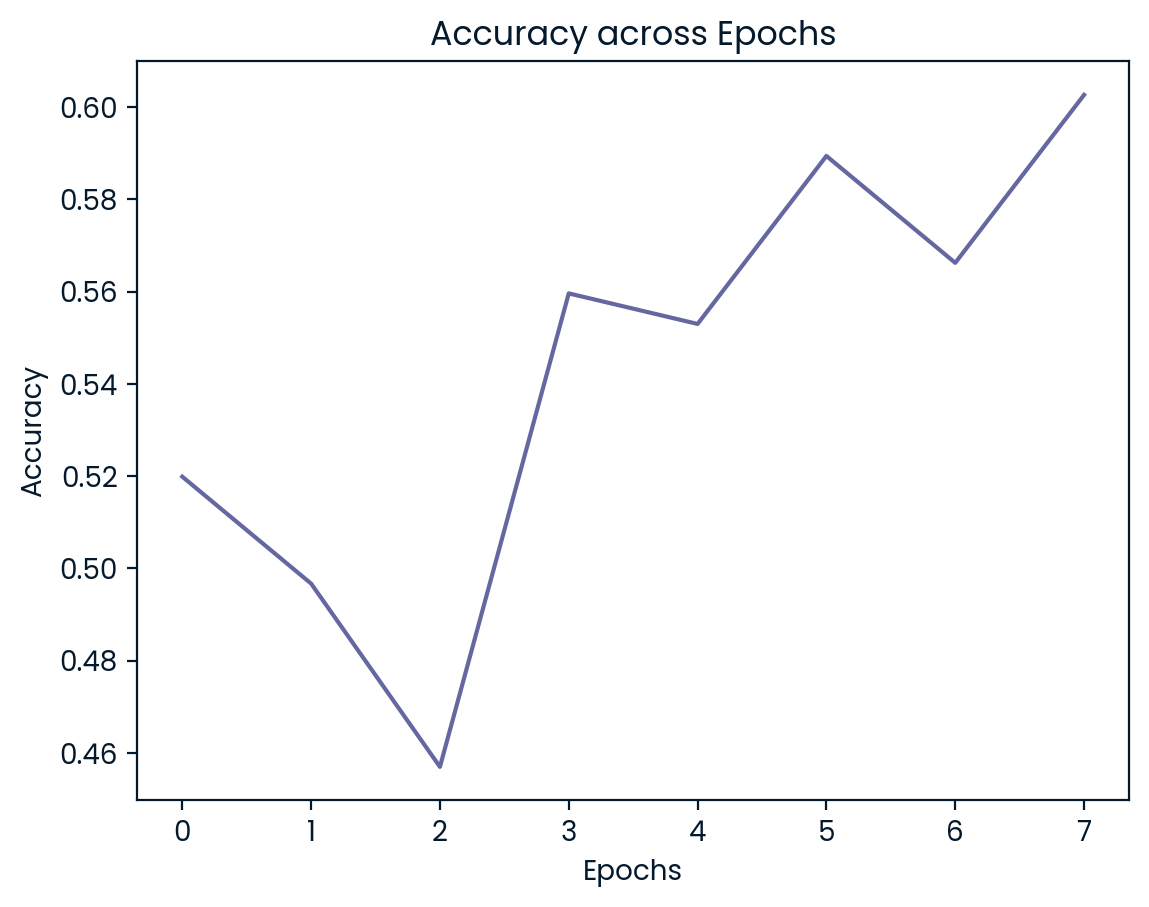

In [17]:
plt.plot(history.history['accuracy'], label ='Training Accuracy')
plt.title('Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 799ms/step
              precision    recall  f1-score   support

     healthy       0.52      1.00      0.68        50
          tb       1.00      0.06      0.11        50

    accuracy                           0.53       100
   macro avg       0.76      0.53      0.40       100
weighted avg       0.76      0.53      0.40       100



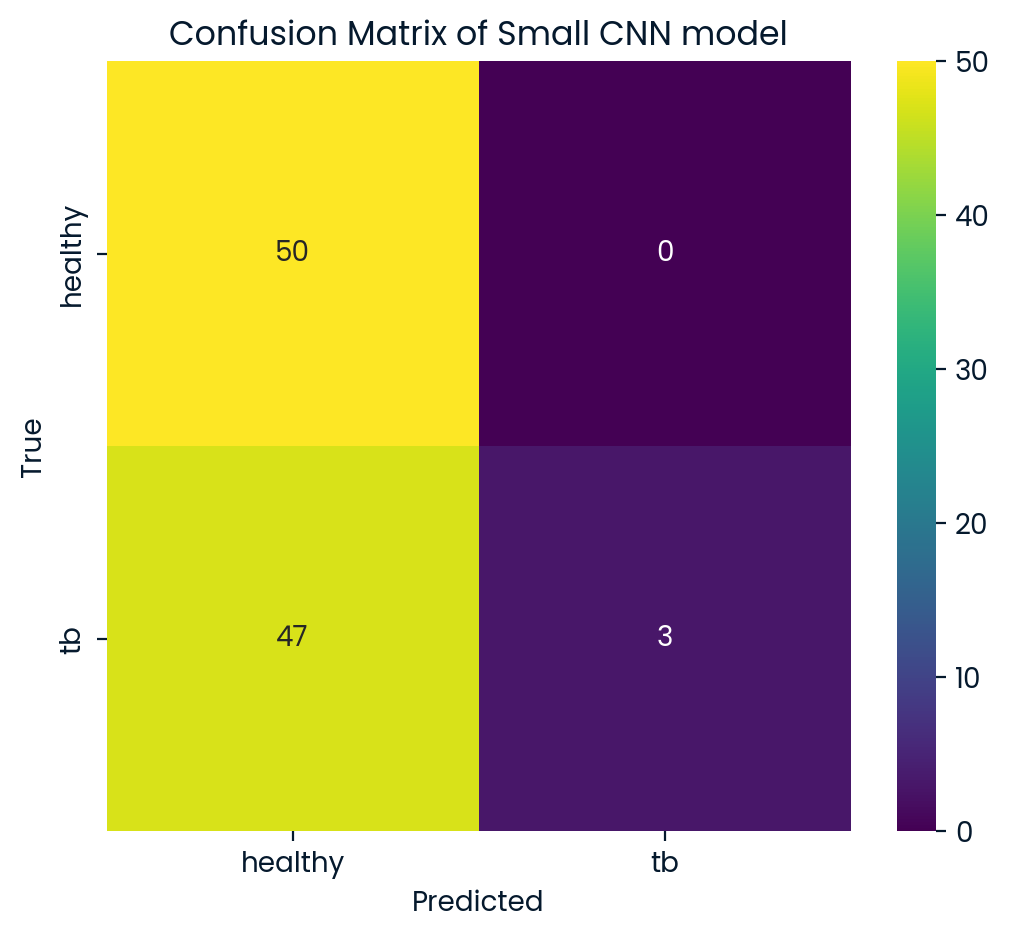

In [18]:
# Get true labels for the test set
y_true = test_generator.classes

# Get predicted probabilities and convert to class indices
y_pred_probs = small_cnn.predict(test_generator)
y_pred_0 = np.where(y_pred_probs > 0.5, 1, 0)

# Get class indices to class label mapping
# class_indices = test_generator.class_indices 
# # Sort by index to get correct order
# class_labels = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]
class_name = ['healthy', 'tb']
# Classification report
print(classification_report(y_true, y_pred_0, target_names=class_name))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_0)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Small CNN model")
plt.show()

# [AUC-ROC Curve](https://www.datacamp.com/tutorial/auc)

AUC values provide a quick reference to understand how well the model is performing. 

- When AUC is close to 1, our model is at the top of its game. It shows excellent performance with a strong ability to distinguish between classes.

- AUC around 0.5 is a concerning scenario, as it highlights that the model isn’t doing any better than random guessing, signaling no discriminatory power.

-*So, it's safe to say that the small cnn model is not doing better than random guessing.*

- An AUC score closer to 0 is an alarming situation. This indicates the model is getting it entirely wrong, even worse than a coin toss

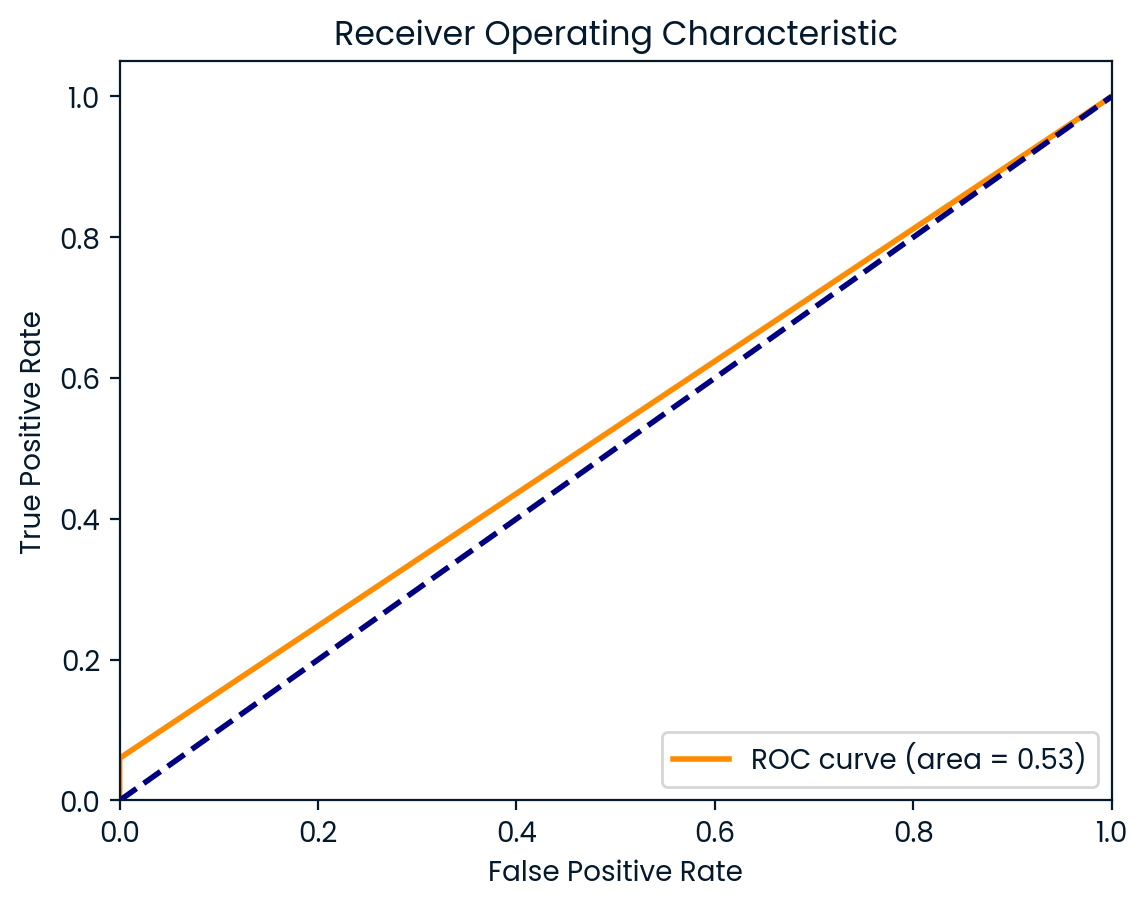

In [21]:
from sklearn.metrics import roc_curve, auc
# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




# [DenseNet121 model](https://www.geeksforgeeks.org/computer-vision/densenet-explained/)
DenseNet, short for Dense Convolutional Network, is a deep learning architecture for convolutional neural networks (CNNs). DenseNet revolutionized the field of computer vision by proposing a novel connectivity pattern within CNNs, addressing challenges such as feature reuse, vanishing gradients, and parameter efficiency.

In [19]:
from keras.applications import DenseNet121

#instantiate model
transfer_learn_model = DenseNet121(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)

transfer_learn_model.trainable = False

x = transfer_learn_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs=transfer_learn_model.input, outputs=output)



In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,562,817 (28.85 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
call_back = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor="accuracy",
    verbose=1,
    mode = 'max',
    save_best_only=True,
)

In [22]:
model.compile(
   optimizer=tf.keras.optimizers.RMSprop(),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [23]:
epochs = 8

#train model
history = model.fit(train_generator,
                               steps_per_epoch = train_generator.samples// train_generator.batch_size,
                                         epochs = epochs, callbacks = [call_back])

Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4980 - loss: 1.6858 - precision: 0.4923 - recall: 0.5162
Epoch 1: accuracy improved from -inf to 0.50871, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4985 - loss: 1.6618 - precision: 0.4935 - recall: 0.5161
Epoch 2/8
 1/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4000 - loss: 0.6955 - precision: 0.2500 - recall: 0.4000
Epoch 2: accuracy did not improve from 0.50871
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 698us/step - accuracy: 0.4000 - loss: 0.6955 - precision: 0.2500 - recall: 0.4000
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6233 - loss: 0.7862 - precision: 0.6400 - recall: 0.5860
Epoch 3: accuracy improved from 0.50871 to 0.58885, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6217 - loss: 0.7881 - precision: 0.6376 - recall: 0.5837
Epoch 4/8
 1/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8000 - loss: 0.4464 - precision: 

In [24]:
test_loss, test_acc, precision, recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8731 - loss: 0.5032 - precision: 0.6250 - recall: 0.2975
Test Accuracy: 0.72


In [27]:
model.save("best_densenet.h5")

## Evaluation of DenseNet121 Model
- It have an overall performance (accuracy) of 0.72, which means it got 72% of the total prediction right.
  
- The DenseNet model accurately detected all negative cases (Healthy chest x-rays) with a recall score of 100%. However, it only detected 44% of the total postivie cases (Tb). This can pose significant consequences in healthcare as detection of positive cases is paramount. 

**Positive predictive value and negatuve predictive value**

True Positives (TP): Correctly predicted positive cases. = 22
False Positives (FP): Incorrectly predicted positive cases (actual negative, predicted positive). 28
True Negatives (TN): Correctly predicted negative cases. 50
False Negatives (FN): Incorrectly predicted negative cases (actual positive, predicted negative). 0

- Positive predictive value = TP/TP+FP = 22/22+28 = 0.44

  
**When the DenseNet121 model says a chest X-ray image is infected with Tb , it is 44% right**

 - negatIve predictive value = TN/TN+FN = 50/0+50 = 1

**when the DenseNet121 model says a chest X-ray image is healthy, it is 100% right**

In [38]:
# Get true labels for the test set
y_true = test_generator.classes

# Get predicted probabilities for test set
y_pred_probs = model.predict(test_generator)

# Convert probabilities into class labels (0 or 1)
y_pred_1 = (y_pred_probs > 0.5).astype("int32").ravel()

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


              precision    recall  f1-score   support

     healthy       0.64      1.00      0.78        50
          tb       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



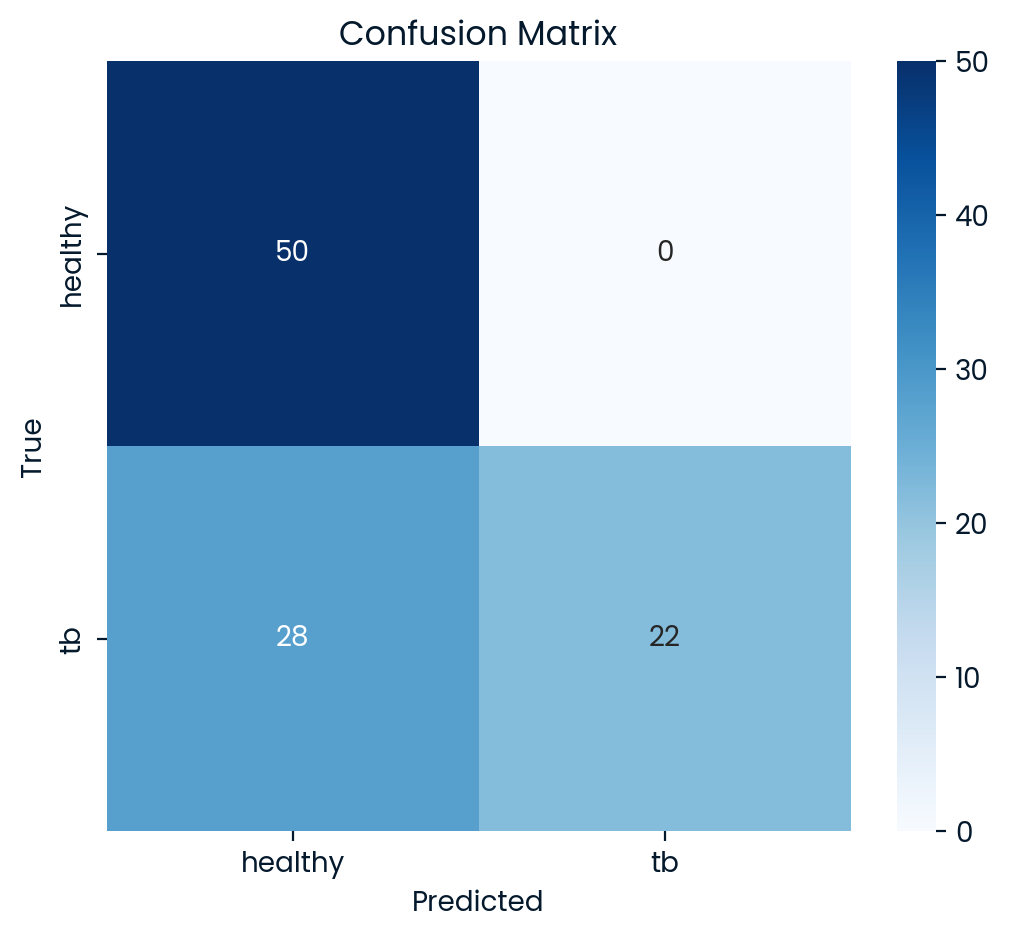

In [39]:
# Get class indices to class label mapping
class_indices = test_generator.class_indices  # dict: class_name -> index
# Sort by index to get correct order
class_labels = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]

# Classification report
print(classification_report(y_true, y_pred_1, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_1)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()